In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#GlobalFinMonthly
url="https://raw.githubusercontent.com/amoreira2/Lectures/4b95c7d60e869dffa6367c1730183b68920ed2b9/assets/data/GlobalFinMonthly.csv"
Data = pd.read_csv(url,na_values=-99)
Data['Date']=pd.to_datetime(Data['Date'])
Data=Data.set_index(['Date'])

# Case study on international portfolio diversification

In this section we will apply what we have learned so far on the international market. We will try to solve the optimal weights that give us the highest sharpe ratio, and how we should allocate our money between risk-free rate and risky asset to target on average return or volatility.


In [4]:
Data.head()

,RF,MKT,USA30yearGovBond,EmergingMarkets,WorldxUSA,WorldxUSAGovBond
Date,,,,,,
1963-02-28,0.0023,-0.0215,-0.001878,0.098222,-0.002773,NaN
1963-03-31,0.0023,0.0331,0.003342,0.014149,0.000371,0.001913
1963-04-30,0.0025,0.0476,-0.001843,-0.147055,-0.003336,0.008002
1963-05-31,0.0024,0.0200,-0.001807,-0.012172,-0.000186,0.004689
1963-06-30,0.0023,-0.0177,0.001666,-0.055699,-0.011160,0.003139


In [5]:
# for convenience lets rename these assets

Data=Data.rename(columns={Data.columns[1]: "MKTUS",Data.columns[2]: "BondUS",
                          Data.columns[3]: "EM",Data.columns[4]: "MKTxUS",Data.columns[5]: "BondxUS" })
Data.tail()

,RF,MKTUS,BondUS,EM,MKTxUS,BondxUS
Date,,,,,,
2016-08-31,0.0002,0.0052,-0.008417,0.025186,0.000838,-0.009552
2016-09-30,0.0002,0.0027,-0.016417,0.013153,0.012736,0.009979
2016-10-31,0.0002,-0.0200,-0.049460,0.002474,-0.020383,-0.043476
2016-11-30,0.0001,0.0487,-0.081636,-0.045971,-0.019798,-0.050359
2016-12-31,0.0003,0.0185,-0.005296,0.002904,0.034383,-0.023207


Lets start by constructing a matrix with only excess returns

In [6]:
# 
Re=(Data.drop('RF',axis=1)).subtract(Data['RF'],axis='index')
Re.tail()

,MKTUS,BondUS,EM,MKTxUS,BondxUS
Date,,,,,
2016-08-31,0.0050,-0.008617,0.024986,0.000638,-0.009752
2016-09-30,0.0025,-0.016617,0.012953,0.012536,0.009779
2016-10-31,-0.0202,-0.049660,0.002274,-0.020583,-0.043676
2016-11-30,0.0486,-0.081736,-0.046071,-0.019898,-0.050459
2016-12-31,0.0182,-0.005596,0.002604,0.034083,-0.023507


Now we estimate the expected return and the covariance using the sample moments

In [7]:
ERe=Re.mean()
ERe

MKTUS      0.005140
BondUS     0.002523
EM         0.006923
MKTxUS     0.004149
BondxUS    0.002054
dtype: float64

Now we estimate the covariance matrix 

In [8]:
CovRe=Re.cov()
CovRe

,MKTUS,BondUS,EM,MKTxUS,BondxUS
MKTUS,0.001948,0.000111,0.001292,0.001264,0.000187
BondUS,0.000111,0.001227,-0.000204,-0.000013,0.000264
EM,0.001292,-0.000204,0.003556,0.001661,0.000249
MKTxUS,0.001264,-0.000013,0.001661,0.002182,0.000422
BondxUS,0.000187,0.000264,0.000249,0.000422,0.000407


1. First we will solve for the maxium Sharpe ratio feasible: 

  $\begin{align}
  SR(R^*)&=\sqrt{E[R^e]'Var(R^e)^{-1}E[R^e]}
  \end{align}$

2. Then we will solve for the weights that implement this Sharpe ratio

  $$W_*=VAR(R^e)^{-1}E[R^e]$$

3. And then we will solve for the position on it that implements a desired level of volatility or expected returns

In [10]:
SR_int=(ERe @ np.linalg.inv(CovRe) @ ERe)**0.5
SR_int

0.163687548954056

In [11]:
# annualized

SR_int*12**0.5

0.5670303027096856

In [12]:
# compares with market

Re.MKTUS.mean()/Re.MKTUS.std()*12**0.5

0.4034509726765917

We will now initate an empty dataframe that has in the columns the names of the assets

We will use it to store the different portfolios that you solve for

In [41]:
Wmve=pd.DataFrame([],index=Re.columns)
Wmve

""
MKTUS
BondUS
EM
MKTxUS
BondxUS


In [42]:
Wmve['International'] =np.linalg.inv(CovRe) @ ERe
Wmve


,International
MKTUS,1.835334
BondUS,1.423373
EM,1.605223
MKTxUS,-1.026421
BondxUS,3.365823


**Targeting desired Voaltiltiy**

We will first find the particular scaling of the tangendy porfolio that implements a desired level of volatility

As we previously saw


$$W^*(\sigma^D)'=\frac{\sigma^D}{\sqrt{E[R^e]'Var(R^e)^{-1}E[R^e]}}E[R^e]'Var(R^e)^{-1}$$

where the denominator is the Sharpe Ratio of the tangency

$$W^*(\sigma^D)=\frac{\sigma^D}{SR_*}W^*$$

So you simply scale down the weights depending on whether your desired volatiltiy.

In this case the obtained expected excess return is

$$\mu^D-r_f=\frac{\sigma^D}{SR_*}E[W^*R^e]=\frac{\sigma^D}{SR_*}SR_*^2=\sigma^DSR^*$$

In [43]:
# I am setting the target to be annual volatiltiy of 20% and 
# I am converting back to monthly by dividing by square roo of 12
sigma_desired=0.20/12**0.5
print(sigma_desired/SR_int)
Wmve['International(voltarget)']=(sigma_desired/SR_int)*(np.linalg.inv(CovRe) @ ERe)
Wmve

0.35271483559918


,International,International(voltarget)
MKTUS,1.835334,0.647349
BondUS,1.423373,0.502045
EM,1.605223,0.566186
MKTxUS,-1.026421,-0.362034
BondxUS,3.365823,1.187176


**Targeting Desired Expected Return**

  $\begin{align}
  \mu^{D}&=r_f+wE[R^*] \\
  w &=\frac{\mu^{D}-r_f}{E[R^*]} \\
  &=\frac{\mu^{D}-r_f}{E[R^e]'VAR(R^e)^{-1}E[R^e]} \\
  &=\frac{\mu^{D}-r_f}{SR_*^2} \\
  \end{align}$

where the last step simply uses that the denominator is the square of the Sharpe Ratio of the tangency portfolio

In this case the portfolio volatiliy is simply

$$\sigma^D=\frac{\mu^{D}-r_f}{SR_*^2}STD(R^*)=\frac{\mu^{D}-r_f}{SR_*^2}SR_*=\frac{\mu^{D}-r_f}{SR_*}$$

Here below I will simply set a target for the desired expected excess return

If one wanted to set the target for the expected returns one ould simply subtract the **current** risk-free rate of this desired level

In [68]:
# I am setting an annual target to 10% and convert to monthly by dividing by 12

mu_desired=0.10/12
#If setting target to expected return simply use mu_desired-rf instead of mu_desired in the formulas

print(mu_desired/SR_int**2)
Wmve['International(mutarget)']=(mu_desired/SR_int**2)*(np.linalg.inv(CovRe) @ ERe)
Wmve

0.31101938812939134


,International,International(voltarget),International(mutarget),Domestic,Domestic(voltarget),Domestic(mutarget)
MKTUS,1.835334,0.647349,0.570824,2.534954,1.101918,0.159048
BondUS,1.423373,0.502045,0.442696,1.827591,0.794434,0.114667
EM,1.605223,0.566186,0.499255,NaN,NaN,NaN
MKTxUS,-1.026421,-0.362034,-0.319237,NaN,NaN,NaN
BondxUS,3.365823,1.187176,1.046836,NaN,NaN,NaN


**Domestic Tangency Portfolio**

we only keep the first two columns MKT and Bonds

In [45]:
ERe_dom=ERe[['MKTUS','BondUS']]
CovRe_dom=CovRe.loc[['MKTUS','BondUS'],['MKTUS','BondUS']]

The Sharpe Ratio of the domestic Tangency portolio

In [46]:
SR_dom=(ERe_dom @ np.linalg.inv(CovRe_dom) @ ERe_dom)**0.5
print(SR_dom*12**0.5)

0.4600987547084185


The weights of the domestic tangency portfolio

In [69]:
Wmvedom= np.linalg.inv(CovRe_dom) @ ERe_dom.values
Wmve.loc[['MKTUS','BondUS'],'Domestic']=Wmvedom

sigma_desired=0.20/12**0.5
print(sigma_desired/SR_dom)
Wmve.loc[['MKTUS','BondUS'],'Domestic(voltarget)']=(sigma_desired/SR_dom)*(np.linalg.inv(CovRe_dom) @ ERe_dom)

mu_desired=0.10/12
print(mu_desired/SR_dom**2)
Wmve.loc[['MKTUS','BondUS'],'Domestic(mutarget)']=(mu_desired/SR_dom**2)*(np.linalg.inv(CovRe_dom) @ ERe_dom)


Wmve

0.43468928779593713
0.47238694231134754


,International,International(voltarget),International(mutarget),Domestic,Domestic(voltarget),Domestic(mutarget)
MKTUS,1.835334,0.647349,0.570824,2.534954,1.101918,1.197479
BondUS,1.423373,0.502045,0.442696,1.827591,0.794434,0.863330
EM,1.605223,0.566186,0.499255,NaN,NaN,NaN
MKTxUS,-1.026421,-0.362034,-0.319237,NaN,NaN,NaN
BondxUS,3.365823,1.187176,1.046836,NaN,NaN,NaN


**The difference in Sharpe ratios reveal the benefits of internaitonal diversificaiton**

In [48]:
# this difference is the benefits of international diversification

(SR_int-SR_dom)*12**0.5

0.10693154800126711

- what does that mean?

- it means for example that if you want to target a portfolio with a volatility of 5% per month (about the vol of the US market portfolio), then you get  


In [62]:
# international diversification
voltarget=0.2/12**0.5
[SR_int*voltarget,SR_dom*voltarget]


[0.009450505045161428, 0.007668312578473642]

In [64]:
# annualized  your returns increase by 
(SR_int*voltarget -SR_dom*voltarget)*12

0.02138630960025343

In [65]:
# in percentual increase it is very meaningful
(SR_int*voltarget -SR_dom*voltarget)/(SR_dom*voltarget)

0.23240999221793937

**The mean-variance frontier in it's full glory**

We will now plot the two frontiers together with the underlying assets

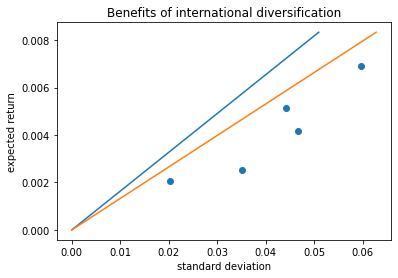

In [74]:
# Lets visualize this in a plot including the two investment frontiers

# set different expected return targets
mu_target=np.linspace(0,0.1/12,20)
# international portfolios

plt.plot(mu_target/SR_int,mu_target)

#Domestic portfolios
plt.plot(mu_target/SR_dom,mu_target)
#Individual assets
plt.xlabel('standard deviation')
plt.ylabel('expected return')
plt.title('Benefits of international diversification')
plt.scatter(Re.std(),Re.mean())




Lets add label to the dots so we know which asset corresponds to each point

For that I will run the same code above and add a for loop that lopps though the column name of the `Re` dataframe and uses the text functio to write the column name in the correct position where the x-dimension is the asset volatility and y-dimension is the asset avereage return

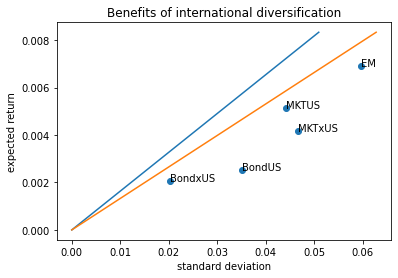

In [73]:
mu_target=np.linspace(0,0.1/12,20)
plt.plot(mu_target/SR_int,mu_target)
plt.plot(mu_target/SR_dom,mu_target)
plt.scatter(Re.std(),Re.mean())

plt.xlabel('standard deviation')
plt.ylabel('expected return')
plt.title('Benefits of international diversification')
# lets add some labels so we know which point is each portfolio


for label in Re.columns :
   plt.text(Re.std()[label],Re.mean()[label],label)

